## High-Value Customer Classification ##

Using the AdventureWorks 2019 database, can we predict how much revenue will be generated by each new customer before they make a purchase (based solely on their demographic information)? To do this we will define the customer base as regular or high-value and implement a classification model that aims to predict which class a customer belongs to.

## Data Sourcing ##

Since the dataset is large we will import it into the notebook using a connection to the SQL Server Database with a query developed in SQL Server ( see hv-query.sql). The query extracts the demographic information about each individual customer along with their total purchases. 

In [210]:
import pyodbc
import pandas as pd
import numpy as np
import sqlalchemy
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#server and database names are stored in a separate file
with open("connect.json") as f:
    db_info = json.load(f)


connection_string = "DRIVER={ODBC Driver 17 for SQL Server};SERVER="+db_info["server"]+";DATABASE="+db_info["database"]+";Trusted_Connection=YES"

connection_url = sqlalchemy.engine.URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})

conn = sqlalchemy.create_engine(connection_url)


# load query developed in ssms
with open("hv-query.sql", "r") as f:
    query = f.read()

import pandas as pd
df = pd.read_sql_query(query, conn)


df.head()



,BirthYear,MaritalStatus,Education,YearlyIncome,Gender,TotalChildren,Occupation,CommuteDistance,NumberCarsOwned,HomeOwnerFlag,TerritoryID,Total_Purchases
0,1943,M,Bachelors,25001-50000,M,1,Clerical,0-1 Miles,0,1,10,3481.1901
1,1968,M,Bachelors,50001-75000,M,2,Professional,2-5 Miles,1,1,9,5893.2413
2,1955,M,Partial College,greater than 100000,F,3,Professional,5-10 Miles,3,1,10,3308.4676
3,1968,S,Bachelors,50001-75000,F,2,Skilled Manual,0-1 Miles,1,0,4,1934.8329
4,1979,M,Partial College,0-25000,M,0,Manual,2-5 Miles,1,1,9,71.2394


## Data Exploration + Cleaning ##

Let's do some basic exploration of the data to to make sure everything is set up for modeling

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BirthYear        18484 non-null  int64  
 1   MaritalStatus    18484 non-null  object 
 2   Education        18484 non-null  object 
 3   YearlyIncome     18484 non-null  object 
 4   Gender           18484 non-null  object 
 5   TotalChildren    18484 non-null  int64  
 6   Occupation       18484 non-null  object 
 7   CommuteDistance  18484 non-null  object 
 8   NumberCarsOwned  18484 non-null  int64  
 9   HomeOwnerFlag    18484 non-null  object 
 10  TerritoryID      18484 non-null  int64  
 11  Total_Purchases  18484 non-null  float64
dtypes: float64(1), int64(4), object(7)
memory usage: 1.7+ MB


In [212]:
df.isna().sum()

BirthYear          0
MaritalStatus      0
Education          0
YearlyIncome       0
Gender             0
TotalChildren      0
Occupation         0
CommuteDistance    0
NumberCarsOwned    0
HomeOwnerFlag      0
TerritoryID        0
Total_Purchases    0
dtype: int64

In [213]:
df.describe()

,BirthYear,TotalChildren,NumberCarsOwned,TerritoryID,Total_Purchases
count,18484.000000,18484.000000,18484.000000,18484.000000,18484.000000
mean,1961.579961,1.844352,1.502705,5.898399,1755.103826
std,11.249188,1.612408,1.138394,3.061200,2347.276065
min,1910.000000,0.000000,0.000000,1.000000,2.530500
25%,1954.000000,0.000000,1.000000,4.000000,55.216900
50%,1963.000000,2.000000,2.000000,6.000000,298.643000
75%,1970.000000,3.000000,2.000000,9.000000,2774.958950
max,1980.000000,5.000000,4.000000,10.000000,14691.395000


It is concerning that there were customers born as early as 1910 given the database references data between 2011-2014. Though this isn't impossible it could be an error in entry: lets limit the customers to those born 70 years or less before the database converage dates (2011-70 = 1941)

In [214]:
df.drop(df[df.BirthYear < 1941].index, inplace=True)

array([[<Axes: title={'center': 'Total_Purchases'}>]], dtype=object)

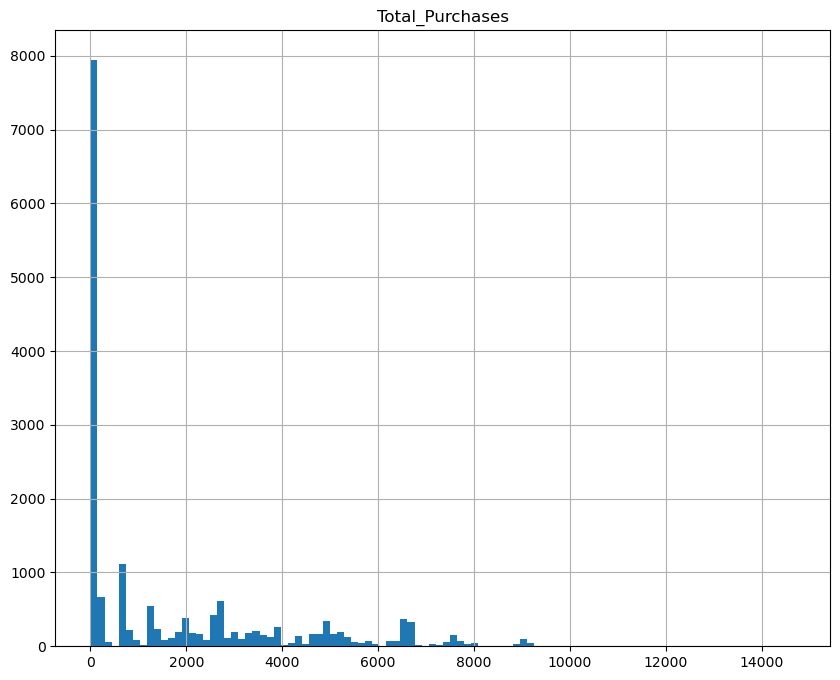

In [215]:
df.hist(column='Total_Purchases',bins=100,figsize=(10,8))

## Preprocessing ##

In [216]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler

base_features = df.drop(['Total_Purchases'], axis=1).columns.to_list()

In [217]:


df["HighValue"] = ""
df.loc[df['Total_Purchases'] >= 500, 'HighValue'] = 1
df.loc[df['Total_Purchases'] < 500, 'HighValue'] = 0


df.loc[df['MaritalStatus'] == 'M', 'MaritalStatus'] = 0
df.loc[df['MaritalStatus'] == 'S', 'MaritalStatus'] = 1

df.loc[df['Gender'] == 'M', 'Gender'] = 0
df.loc[df['Gender'] == 'F', 'Gender'] = 1

nominal_feat = ['Education','Occupation','TerritoryID']


oh= OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded=oh.fit_transform(df[nominal_feat])
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=nominal_feat)


ordinal_feat = ['YearlyIncome',]
ordinal_seq = [['0-25000','25001-50000','50001-75000','75001-100000','greater than 100000']]

oe = OrdinalEncoder(categories = ordinal_seq ).set_output(transform="pandas")
ordinal_encoded = oe.fit_transform(df[ordinal_feat])
df = df.drop(columns=ordinal_feat)
df = pd.concat([df,ordinal_encoded],axis=1)



df.loc[df['CommuteDistance'] == '0-1 Miles', 'CommuteDistance'] = 0.5
df.loc[df['CommuteDistance'] == '1-2 Miles', 'CommuteDistance'] = 1.5
df.loc[df['CommuteDistance'] == '2-5 Miles', 'CommuteDistance'] = 3.5
df.loc[df['CommuteDistance'] == '5-10 Miles', 'CommuteDistance'] = 7.5
df.loc[df['CommuteDistance'] == '10+ Miles', 'CommuteDistance'] = 15.0


numeric_feat = ['BirthYear','CommuteDistance','YearlyIncome','TotalChildren','NumberCarsOwned']
scaler = MinMaxScaler()
df[numeric_feat] = scaler.fit_transform(df[numeric_feat])

df.head()


,BirthYear,MaritalStatus,Gender,TotalChildren,CommuteDistance,NumberCarsOwned,HomeOwnerFlag,Total_Purchases,HighValue,Education_Bachelors,...,TerritoryID_2,TerritoryID_3,TerritoryID_4,TerritoryID_5,TerritoryID_6,TerritoryID_7,TerritoryID_8,TerritoryID_9,TerritoryID_10,YearlyIncome
0,0.051282,0,0,0.2,0.000000,0.00,1,3481.1901,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.25
1,0.692308,0,0,0.4,0.206897,0.25,1,5893.2413,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.50
2,0.358974,0,1,0.6,0.482759,0.75,1,3308.4676,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00
3,0.692308,1,1,0.4,0.000000,0.25,0,1934.8329,1,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50
4,0.974359,0,0,0.0,0.206897,0.25,1,71.2394,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00


In [218]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

X=df.drop(['Total_Purchases','HighValue'], axis=1)
y=df[['HighValue']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

y_train = y_train.astype(int).values.ravel()
y_test = y_test.astype(int).values.ravel()

## Modeling ## 

In [219]:
def eval_model(model, x_test, y_test):

    y_pred = model.predict(x_test).astype(int)

    acc = accuracy_score(y_test,y_pred)
    pres = precision_score(y_test,y_pred)
    rec = recall_score(y_test,y_pred)

    auc = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])


    print("accuracy:  " , acc)
    print("precision: " , pres)
    print("recall:    " , rec)
    print("AUC:       " , auc)


    return


In [220]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', max_depth =15 )
rfc.fit(X_train, y_train)
eval_model(rfc,X_test,y_test)

accuracy:   0.7929235654343388
precision:  0.7805724197745013
recall:     0.8155867693701858
AUC:        0.862232175963936


Text(0.5, 1.0, 'ROC Curve')

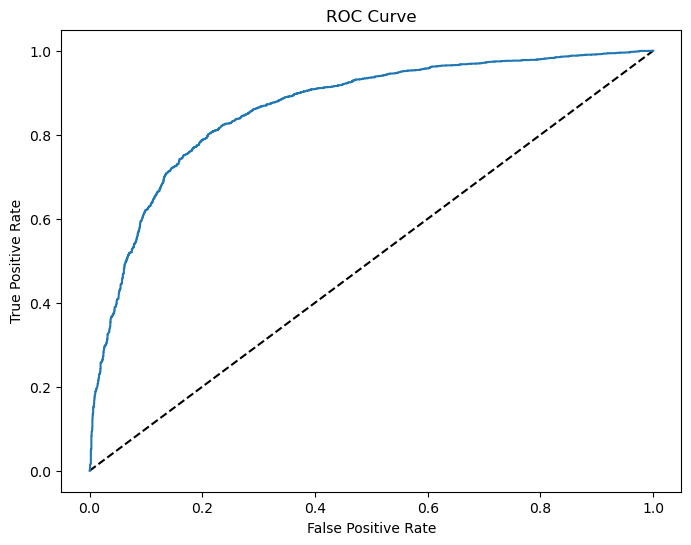

In [221]:
y_pred = rfc.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
fig = plt.figure(figsize=(8, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

<Axes: >

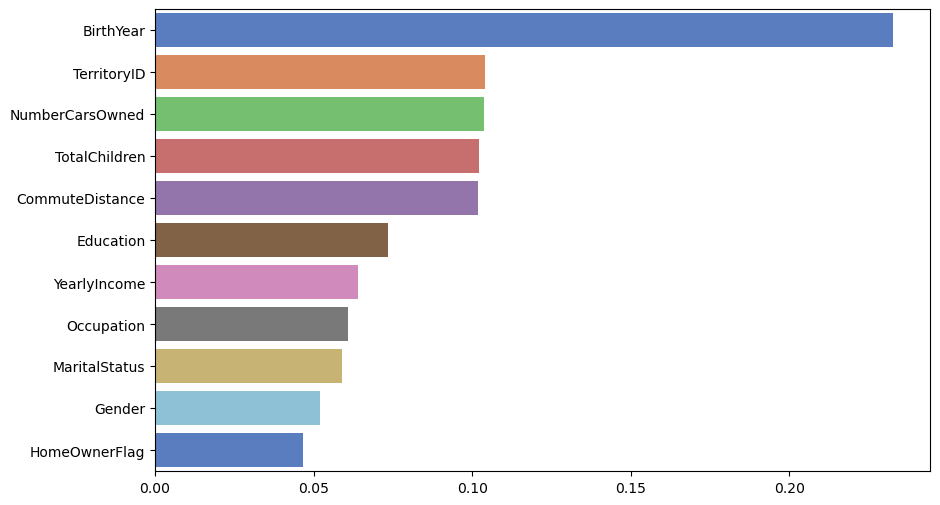

In [222]:
feat_importance = rfc.feature_importances_.tolist()
labels = rfc.feature_names_in_.tolist()


#base_features = nominal_feat + ordinal_feat + numeric_feat
base_importance_agg = [0]*len(base_features)

for feature in base_features:
        
    for sub_category in labels:
            
        if feature in sub_category:
                
            base_importance_agg[base_features.index(feature)] = base_importance_agg[base_features.index(feature)] + feat_importance[labels.index(sub_category)]




feature = labels + base_features
importance = feat_importance + base_importance_agg

final = list(zip(feature,importance))


final_importances = sorted(final,key=lambda x:x[1],reverse=True)

imp_df = pd.DataFrame(final_importances)
base_imp = imp_df[imp_df.iloc[:, 0].isin(base_features)].to_numpy()


# figure size in inches
rcParams['figure.figsize'] = 10,6

sns.barplot(y=base_imp[::,0],x=base_imp[::,1],orient='h',palette = "muted")